<a href="https://colab.research.google.com/github/renaldfredy/Thesis/blob/main/LSTM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import Series
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout, Embedding, TimeDistributed
from keras.initializers import RandomNormal
# from keras.layers import Conv1D, MaxPooling2D
import warnings
import pickle
warnings.filterwarnings("ignore")

In [2]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
np.random.seed(1)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


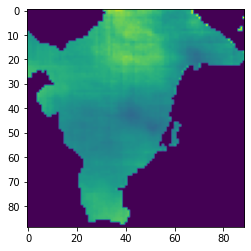

In [4]:
pickle_in = open("/content/drive/MyDrive/Preprosessing_data/rainfall_flatten.pickle","rb")
# data diload sudah dalam bentuk 1D
X = pickle.load(pickle_in)
# untuk menampilkan gambar data 1D -> 2D
plt.imshow(X[-96].reshape(89,89))

In [5]:
df = X

data_4 = df[:-12]

In [6]:
train, valid, test = df[:-96], df[-96:-48], df[-48:]
# len(train)

In [7]:
scaler = MinMaxScaler()
scaler.fit(train)
scaler.fit(data_4)
scaler.fit(valid)
scaler.fit(test)
train = scaler.transform(train)
data_4 = scaler.transform(data_4)
valid = scaler.transform(valid)
test = scaler.transform(test)

In [8]:
n_input = 12
n_features = 7921
batch_size = 12
# supervised data
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=batch_size)
validation_sequence = TimeseriesGenerator(valid,valid, length=n_input, batch_size=12)
test_sequence = TimeseriesGenerator(test,test, length=n_input, batch_size=12)

In [9]:
from keras.layers import *
from keras.models import *
from keras import backend as K

class attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
    def get_config(self):
      config = super().get_config().copy()
      config.update({'return_sequences': self.return_sequences})
      return config
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

model = Sequential()
model.add(LSTM(228, input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(300, return_sequences=True))
model.add(LSTM(400, return_sequences=True))
model.add(LSTM(500, return_sequences=True))
model.add(attention(return_sequences=False)) # receive 3D and output 3D
model.add(Dense(n_features, activation='ReLU', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=1)))
optimizer = keras.optimizers.Adam(learning_rate=0.001)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Weight_LSTM/LSTM_weights.hdf5' , verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=100, verbose=0)
with open("/content/drive/MyDrive/Weight_LSTM/LSTM.json", "w") as m:
  m.write(model.to_json())



In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 228)           7432800   
                                                                 
 lstm_1 (LSTM)               (None, 12, 300)           634800    
                                                                 
 lstm_2 (LSTM)               (None, 12, 400)           1121600   
                                                                 
 lstm_3 (LSTM)               (None, 12, 500)           1802000   
                                                                 
 attention (attention)       (None, 500)               512       
                                                                 
 dense (Dense)               (None, 7921)              3968421   
                                                                 
Total params: 14,960,133
Trainable params: 14,960,133
No

In [12]:
history = model.fit(generator, epochs=1000, validation_data=validation_sequence)#, callbacks=[checkpointer, earlystopper])

Epoch 1/1000
31/31 [==============================] - 13s 76ms/step - loss: 0.0778 - mse: 0.0778 - val_loss: 0.0585 - val_mse: 0.0585
Epoch 2/1000
31/31 [==============================] - 1s 17ms/step - loss: 0.0655 - mse: 0.0655 - val_loss: 0.0574 - val_mse: 0.0574
Epoch 3/1000
31/31 [==============================] - 1s 17ms/step - loss: 0.0647 - mse: 0.0647 - val_loss: 0.0630 - val_mse: 0.0630
Epoch 4/1000
31/31 [==============================] - 1s 17ms/step - loss: 0.0649 - mse: 0.0649 - val_loss: 0.0572 - val_mse: 0.0572
Epoch 5/1000
31/31 [==============================] - 1s 18ms/step - loss: 0.0650 - mse: 0.0650 - val_loss: 0.0600 - val_mse: 0.0600
Epoch 6/1000
31/31 [==============================] - 1s 18ms/step - loss: 0.0655 - mse: 0.0655 - val_loss: 0.0585 - val_mse: 0.0585
Epoch 7/1000
31/31 [==============================] - 1s 17ms/step - loss: 0.0641 - mse: 0.0641 - val_loss: 0.0587 - val_mse: 0.0587
Epoch 8/1000
31/31 [==============================] - 1s 17ms/step -

In [14]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

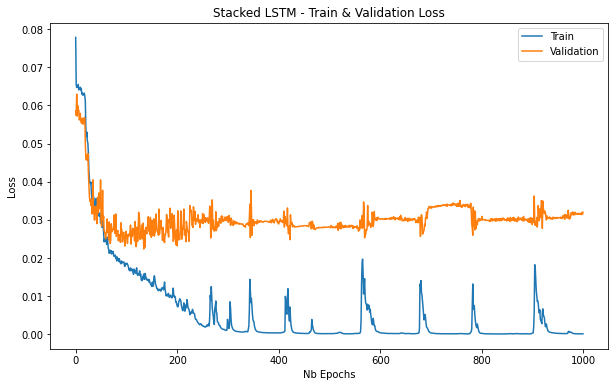

Minimum validation loss of 0.02235855907201767 reached at epoch 134


In [15]:
plot_loss(history, 'Stacked LSTM - Train & Validation Loss')

In [ ]:
def eval_best_model(model_architecture):
    # Load model architecture from JSON
    model_architecture = open('/content/drive/MyDrive/Weight_LSTM/'+model_architecture+'.json', 'r')
    best_model = model_from_json(model_architecture.read())
    model_architecture.close()
    # Load best model's weights
    best_model.load_weights('/content/drive/MyDrive/Weight_LSTM/'+model_architecture+'_weights.hdf5')
    # Compile the best model
    best_model.compile(loss='mean_squared_error', optimizer='adam')
    # Evaluate on test data
    perf_best_model = best_model.evaluate_generator(test_sequence)
    print('Loss on test data for {} : {}'.format(model, perf_best_model))

# eval_best_model('simple_rnn')
# eval_best_model('simple_lstm')
eval_best_model('LSTM')

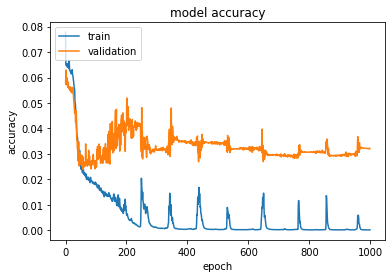

In [ ]:
# summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

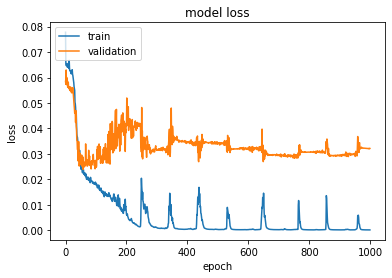

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
pred_list = []

batch = train[-12:].reshape((1, n_input, n_features))
batch

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [ ]:
for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

pred_list = scaler.inverse_transform(pred_list)

# prediksi = (model.predict(batch)[0])

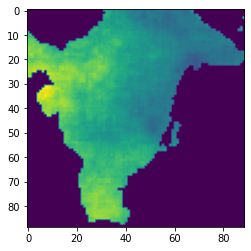

In [ ]:
plt.imshow(pred_list[0].reshape(89,89))

In [ ]:
# pred_list = []

# batch = data_4[-60:-48].reshape((1, n_input, n_features))

# for i in range(n_input):   
#     pred_list.append(model.predict(batch)[0]) 
#     batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
    
# batch1 = data_4[-48:-36].reshape((1, n_input, n_features))

# for i in range(n_input):   
#     pred_list.append(model.predict(batch1)[0]) 
#     batch1 = np.append(batch1[:,1:,:],[[pred_list[i]]],axis=1)
    
# batch2 = data_4[-36:-24].reshape((1, n_input, n_features))

# for i in range(n_input):   
#     pred_list.append(model.predict(batch2)[0]) 
#     batch2 = np.append(batch2[:,1:,:],[[pred_list[i]]],axis=1)
    
# # data tahun 2018 untuk memprediksi tahun 2019
# batch3 = data_4[-24:-12].reshape((1, n_input, n_features))

# for i in range(n_input):   
#     pred_list.append(model.predict(batch3)[0]) 
#     batch3 = np.append(batch3[:,1:,:],[[pred_list[i]]],axis=1)

# # data tahun 2019 untuk memprediksi tahun 2020
# batch4 = data_4[-12:].reshape((1, n_input, n_features))

# for i in range(n_input):   
#     pred_list.append(model.predict(batch4)[0]) 
#     batch4 = np.append(batch4[:,1:,:],[[pred_list[i]]],axis=1)

In [ ]:
# pred_list = scaler.inverse_transform(pred_list)
# pred_list

In [ ]:
pred_list.shape

(12, 7921)

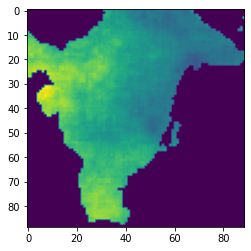

In [ ]:
plt.imshow(pred_list[0].reshape(89,89))

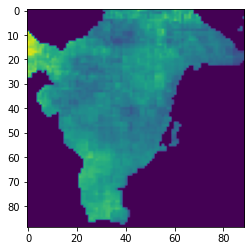

In [ ]:
df_asli = df[:-96]
plt.imshow(df_asli[2].reshape(89,89))

In [ ]:
# MAE untuk semua data
pred_list[pred_list<0]=0
pred_list_new=[]
df_asli_new=[]
no=0
df_asli=np.array(df_asli)
# for pred in pred_list:
#     pred_list_new.append(list(filter(lambda x: x != 0, pred_list[no])))
#     df_asli_new.append(list(filter(lambda x: x != 0, df_asli[no])))
#     no+=1
    
pred_list_new=np.array(pred_list_new)
df_asli_new=np.array(df_asli_new)

# pred_list.shape
# np.array(df_asli_new).shape

mae=[]
no=0
# for pred1 in pred_list:
#     mae_ = df_asli[no]-pred1
#     mae_ = np.average(mae_)
#     mae.append(mae_)
#     no+=1
from sklearn.metrics import mean_absolute_error
for pred1 in pred_list:
    mae_ = mean_absolute_error(df_asli[no], pred1)
    mae.append(mae_)
    no+=1

In [ ]:
mae

[90.5659912328386,
 104.61208631622618,
 58.52202180041129,
 116.57449573439698,
 82.52870377797187,
 104.14034528566293,
 82.34190224789965,
 9.955919210879246,
 75.72734234100231,
 77.68462080908077,
 116.18532422111204,
 147.73079964831544,
 130.68573462633606,
 127.3994959992309,
 104.27484843995498,
 145.37307870702443,
 84.20105567519288,
 51.87132474341182,
 9.090764244604058,
 13.022500873103406,
 29.823305950738742,
 13.515939738342526,
 45.54558073955883,
 77.35880616764138,
 40.147480099918965,
 24.271481768699925,
 14.839053740185904,
 100.82512030664621,
 38.77632671346607,
 94.51063233350767,
 56.112215160732056,
 102.27692645940617,
 64.10228493678213,
 70.75849722116185,
 139.96353602611077,
 111.11715297229867,
 142.91797290664167,
 113.83906283423741,
 156.8684451008289,
 122.69791833670698,
 145.66316836112455,
 73.23665167296001,
 51.515703611069085,
 92.448348850267,
 92.290996364594,
 57.84756186995731,
 97.68004412278097,
 94.9980411866359,
 126.35094455703718,
 

In [ ]:
# pred_list_new

Pred_rata= []
for i in range(0,60):
	Pred_rata.append((pred_list[i].mean()))

In [ ]:
df_asli_rata= []
for i in range(0,60):
	df_asli_rata.append((df_asli[i].mean()))

In [ ]:
# membuat index tanggal, agar mempudah dalam proses plotting data
awal = "2016-1"
awal = pd.to_datetime(awal)
from pandas.tseries.offsets import DateOffset
add_dates = [awal + DateOffset(months=x) for x in range(0,60) ]
add_dates

[Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-02-01 00:00:00'),
 Timestamp('2016-03-01 00:00:00'),
 Timestamp('2016-04-01 00:00:00'),
 Timestamp('2016-05-01 00:00:00'),
 Timestamp('2016-06-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00'),
 Timestamp('2016-08-01 00:00:00'),
 Timestamp('2016-09-01 00:00:00'),
 Timestamp('2016-10-01 00:00:00'),
 Timestamp('2016-11-01 00:00:00'),
 Timestamp('2016-12-01 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-02-01 00:00:00'),
 Timestamp('2017-03-01 00:00:00'),
 Timestamp('2017-04-01 00:00:00'),
 Timestamp('2017-05-01 00:00:00'),
 Timestamp('2017-06-01 00:00:00'),
 Timestamp('2017-07-01 00:00:00'),
 Timestamp('2017-08-01 00:00:00'),
 Timestamp('2017-09-01 00:00:00'),
 Timestamp('2017-10-01 00:00:00'),
 Timestamp('2017-11-01 00:00:00'),
 Timestamp('2017-12-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-

In [ ]:
dict = {'bulan': add_dates, 'data ':mae}
df = pd.DataFrame(dict)

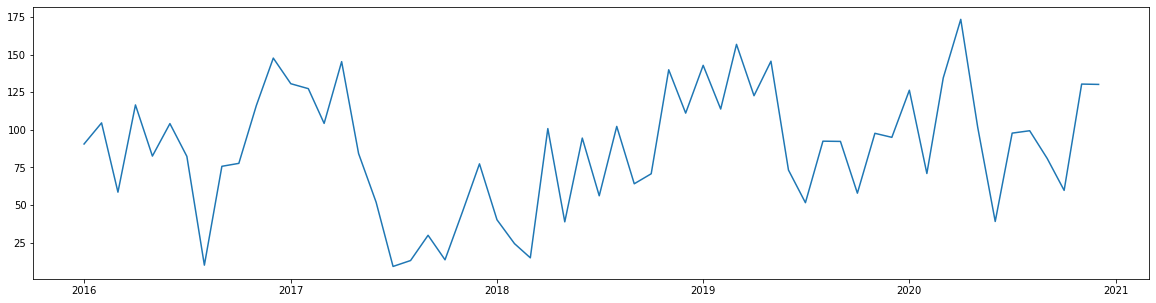

In [ ]:
df = df.set_index("bulan")
plt.figure(figsize=(20, 5))
plt.plot(df.index,df)

In [ ]:
dict = {'bulan': add_dates, 'data prediksi':Pred_rata, 'data asli':df_asli_rata}
df = pd.DataFrame(dict)
df

,bulan,data prediksi,data asli
0,2016-01-01,29.378698,119.939163
1,2016-02-01,29.279048,133.886246
2,2016-03-01,29.224545,87.742004
3,2016-04-01,29.169981,145.740234
4,2016-05-01,29.012099,111.537498
5,2016-06-01,28.872717,133.010574
6,2016-07-01,28.724842,111.065109
7,2016-08-01,28.714971,34.458416
8,2016-09-01,28.743835,104.469414
9,2016-10-01,28.719320,106.402336


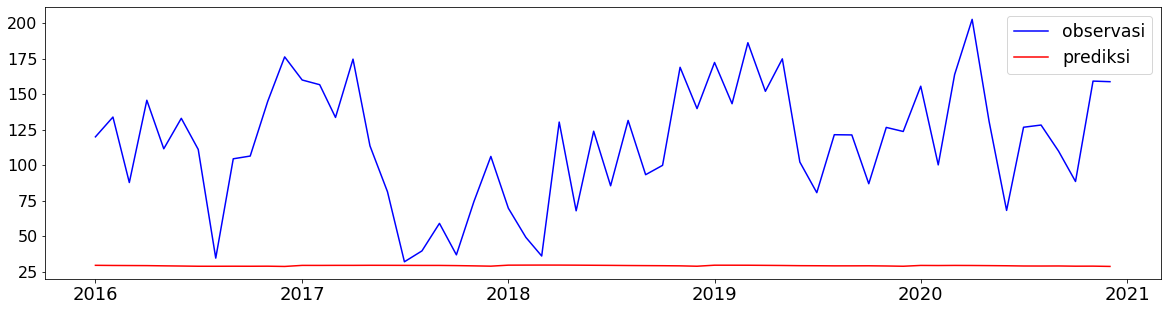

In [ ]:
# df_asli = data_4
df = df.set_index("bulan")
plt.figure(figsize=(20, 5))
plt.plot(df.index, df_asli_rata[-60:], color='b', label="observasi")
plt.plot(df.index, Pred_rata[-60:], color='r', label="prediksi")
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()